In [1]:
pip install fbpca

Note: you may need to restart the kernel to use updated packages.


In [2]:
import nltk
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD, NMF, randomized_svd, LatentDirichletAllocation
import fbpca
import random
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shylu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#file import
#============

df = pd.read_csv("quora_questions.csv", encoding = "ISO-8859-1")
df #.describe()

,Question
0,What is the step by step guide to invest in sh...
1,What is the story of Kohinoor (Koh-i-Noor) Dia...
2,How can I increase the speed of my internet co...
3,Why am I mentally very lonely? How can I solve...
4,"Which one dissolve in water quikly sugar, salt..."
...,...
404284,How many keywords are there in the Racket prog...
404285,Do you believe there is life after death?
404286,What is one coin?
404287,What is the approx annual cost of living while...


In [4]:
# taking only the first 50,000 documents to avoid memory error
#=============================================================
#df = df_orig.head(50000)

# Data Preprocessing

In [5]:
df['Question']=df['Question'].str.lower()  #convert to lower case
df['Question']=df['Question'].str.replace('\d+','') # remove numbers
df['Question']=df['Question'].str.replace('<.*?>','') # remove HTML tags
df['Question']=df['Question'].str.replace('[^\w\s]','') # remove punctuation  
df

,Question
0,what is the step by step guide to invest in sh...
1,what is the story of kohinoor kohinoor diamond
2,how can i increase the speed of my internet co...
3,why am i mentally very lonely how can i solve it
4,which one dissolve in water quikly sugar salt ...
...,...
404284,how many keywords are there in the racket prog...
404285,do you believe there is life after death
404286,what is one coin
404287,what is the approx annual cost of living while...


In [6]:
#lemmatization
#===============

lemmatizer = WordNetLemmatizer()
df['Question']=df['Question'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
df

,Question
0,what is the step by step guide to invest in sh...
1,what is the story of kohinoor kohinoor diamond
2,how can i increase the speed of my internet co...
3,why am i mentally very lonely how can i solve it
4,which one dissolve in water quikly sugar salt ...
...,...
404284,how many keywords are there in the racket prog...
404285,do you believe there is life after death
404286,what is one coin
404287,what is the approx annual cost of living while...


In [7]:
# stemming

#st = SnowballStemmer('english')
#df['Question']=df['Question'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
#df

In [8]:
# remove stopwords

stop = stopwords.words('english')
df['Question'] = df['Question'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df

,Question
0,step step guide invest share market india
1,story kohinoor kohinoor diamond
2,increase speed internet connection using vpn
3,mentally lonely solve
4,one dissolve water quikly sugar salt methane c...
...,...
404284,many keywords racket programming language late...
404285,believe life death
404286,one coin
404287,approx annual cost living studying uic chicago...


In [9]:
df_train, df_test = train_test_split(df,train_size=0.7, test_size=0.3, random_state=0)

print(len(df_train))
print(len(df_test))

283002
121287


In [10]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [11]:
train_vectors = tfidf.fit_transform(df_train['Question']) #.todense() 
train_vectors.shape # (documents, vocab)

(283002, 29464)

In [12]:
test_vectors = tfidf.transform(df_test['Question']) #.todense() 
vocab = np.array(tfidf.get_feature_names())
print(vocab.shape)
vocab[8000:8050]

(29464,)


array(['eenadu', 'effect', 'effected', 'effective', 'effectively',
       'effectiveness', 'effectvely', 'efficacy', 'efficiency',
       'efficient', 'efficiently', 'effort', 'effortlessly', 'efiling',
       'eftpos', 'egalitarian', 'egg', 'eggless', 'eggshell', 'egift',
       'ego', 'egocentric', 'egocãntrico', 'egoism', 'egoist', 'egoistic',
       'egypt', 'egyptian', 'egyptology', 'ehr', 'eid', 'eie', 'eiffel',
       'eigen', 'eigenvalue', 'eigenvectors', 'eighteen', 'eighth', 'ein',
       'einstein', 'eintax', 'eis', 'eisenhower', 'eit', 'eitheror',
       'ejabberd', 'ejaculate', 'ejaculated', 'ejaculating',
       'ejaculation'], dtype='<U86')

In [13]:
print(len(tfidf.get_feature_names()))

#print the random 10 words
#===========================
for i in range(10):
    random_word_id = random.randint(0,29464)
    print(tfidf.get_feature_names()[random_word_id])

29464
wolfram
sulfide
homeschooled
sastra
ligation
njac
graduating
rancid
sicario
biotechnology


In [14]:
def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[combined_inds], rotation=60, ha="right")

# Truncated SVD

In [15]:
model_tsvd = TruncatedSVD(n_components=8,random_state=42)

# fit the model to train data
#==============================
model_tsvd.fit(train_vectors)

TruncatedSVD(algorithm='randomized', n_components=8, n_iter=5, random_state=42,
             tol=0.0)

In [16]:
print(len(model_tsvd.components_))
model_tsvd.components_

8


array([[ 8.79357168e-06,  1.69155216e-05,  6.20138660e-06, ...,
         6.32014167e-06,  2.47732422e-06,  6.10016481e-06],
       [ 1.31104021e-05,  1.19242764e-05,  1.15421120e-05, ...,
         1.15283872e-06,  6.10989497e-06,  9.94144385e-07],
       [ 9.51774344e-08, -6.17248806e-06, -4.90654636e-06, ...,
        -1.91009598e-06, -3.94155067e-06, -1.79488821e-06],
       ...,
       [ 4.65945865e-06,  2.57117497e-06, -8.74373276e-06, ...,
        -3.24842058e-06, -1.88038080e-05, -3.25979011e-06],
       [ 2.75880123e-06, -1.58432810e-06,  5.49062760e-06, ...,
         7.55290048e-05, -1.40201753e-06,  7.53294841e-05],
       [-1.17109383e-05,  2.10001438e-05, -4.19633071e-06, ...,
        -1.06922368e-05, -2.63551402e-05, -1.06868877e-05]])

In [17]:
#print top 15 words for the topics
#==================================
for index,topic in enumerate(model_tsvd.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['language', 'laptop', 'life', 'quora', 'whats', 'doe', 'online', 'make', 'money', 'movie', 'india', 'book', 'learn', 'way', 'best']


THE TOP 15 WORDS FOR TOPIC #1
['know', 'online', 'life', 'work', 'feel', 'ask', 'answer', 'mean', 'money', 'like', 'make', 'people', 'question', 'quora', 'doe']


THE TOP 15 WORDS FOR TOPIC #2
['add', 'post', 'needing', 'answered', 'easily', 'improvement', 'delete', 'google', 'asked', 'best', 'people', 'ask', 'answer', 'question', 'quora']


THE TOP 15 WORDS FOR TOPIC #3
['banning', 'month', 'home', 'rupee', 'easiest', 'good', 'easy', 'black', 'youtube', 'note', 'earn', 'way', 'online', 'make', 'money']


THE TOP 15 WORDS FOR TOPIC #4
['girl', 'purpose', 'new', 'important', 'india', 'whats', 'trump', 'think', 'love', 'day', 'like', 'know', 'thing', 'people', 'life']


THE TOP 15 WORDS FOR TOPIC #5
['indian', 'note', 'war', 'pakistan', 'difference', 'election', 'think', 'hillary', 'clinton', 'president', 'win', 'people', 'do

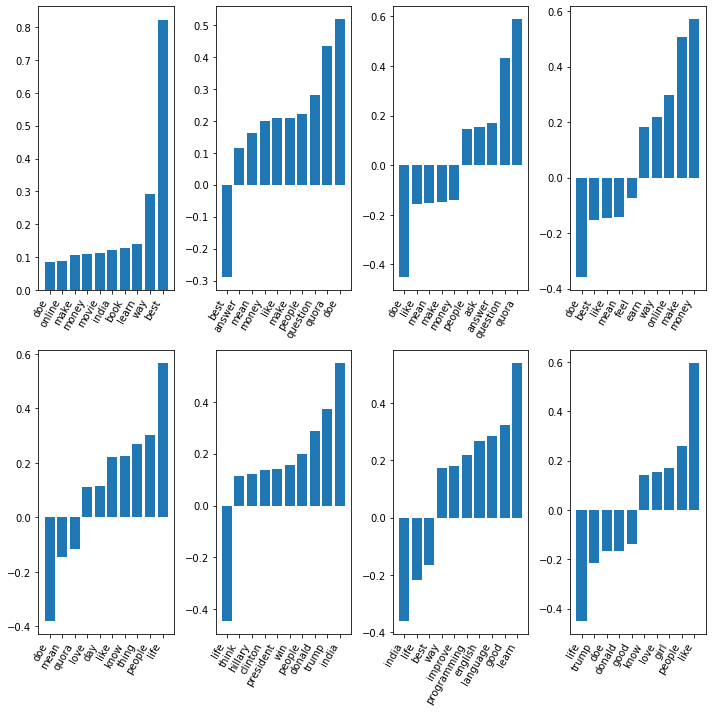

In [18]:
#plot training features
#=======================
feature_names = np.array(tfidf.get_feature_names())
n_components = 8
fig, axes = plt.subplots(2,4, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), model_tsvd.components_):
    plot_important_features(coef, feature_names, top_n=10, ax=ax)
    
plt.tight_layout()

In [19]:
# predict on test set
#=====================

topic_test = model_tsvd.transform(test_vectors)
topic_test.shape

(121287, 8)

In [20]:
topic_test.argmax(axis=1)

array([5, 0, 1, ..., 5, 0, 1], dtype=int64)

In [21]:
df_test['Topic_SVD'] = topic_test.argmax(axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
#print topics predicted for test set
#====================================
df_test.iloc[1:10,:]

,Question,Topic_SVD
6557,best doctor doom story,0
139264,newton ring circular shape square shape,1
240135,doe wikipedia ensure content quality authentic...,1
3336,height would year old increase height,4
238994,many people sex,4
288817,famous story swami vivekananda,0
127604,forget someone love strongly,7
80065,sahara average temperature compare one great v...,1
134165,whats romantic thing anyone ha ever done,4


# Non negative Matrix Factorization - NMF

In [23]:
model_nmf = NMF(n_components=8,random_state=42)

In [25]:
# fit the model to train data
#=============================
model_nmf.fit(train_vectors)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=8, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [26]:
print(len(model_nmf.components_))
model_nmf.components_

8


array([[2.75942045e-05, 6.04395425e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.43635833e-05, 5.69409364e-06, 8.73102881e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.77488087e-05, 1.28217863e-05, 1.67242843e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [4.38656207e-05, 0.00000000e+00, 2.33874742e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.43882125e-05, 2.87867785e-05, ...,
        4.54876906e-04, 3.92804860e-05, 4.53094518e-04],
       [1.32921492e-05, 0.00000000e+00, 8.67932548e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [27]:
#print top 15 words for the topics
#==================================
for index,topic in enumerate(model_nmf.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['friend', 'time', 'site', 'website', 'lose', 'weight', 'buy', 'place', 'phone', 'whats', 'laptop', 'book', 'movie', 'way', 'best']


THE TOP 15 WORDS FOR TOPIC #1
['university', 'look', 'girl', 'say', 'compare', 'really', 'cost', 'sex', 'time', 'long', 'feel', 'work', 'like', 'mean', 'doe']


THE TOP 15 WORDS FOR TOPIC #2
['use', 'add', 'answered', 'needing', 'post', 'easily', 'improvement', 'delete', 'asked', 'google', 'ask', 'people', 'answer', 'question', 'quora']


THE TOP 15 WORDS FOR TOPIC #3
['month', 'friend', 'video', 'easiest', 'rupee', 'home', 'easy', 'note', 'black', 'youtube', 'way', 'earn', 'online', 'make', 'money']


THE TOP 15 WORDS FOR TOPIC #4
['wa', 'dont', 'meaning', 'girl', 'new', 'whats', 'purpose', 'important', 'day', 'love', 'people', 'know', 'like', 'thing', 'life']


THE TOP 15 WORDS FOR TOPIC #5
['ban', 'banning', 'start', 'business', 'company', 'think', 'world', 'job', 'rupee', 'country', 'indian', 'war', 'note', 'pakistan', '

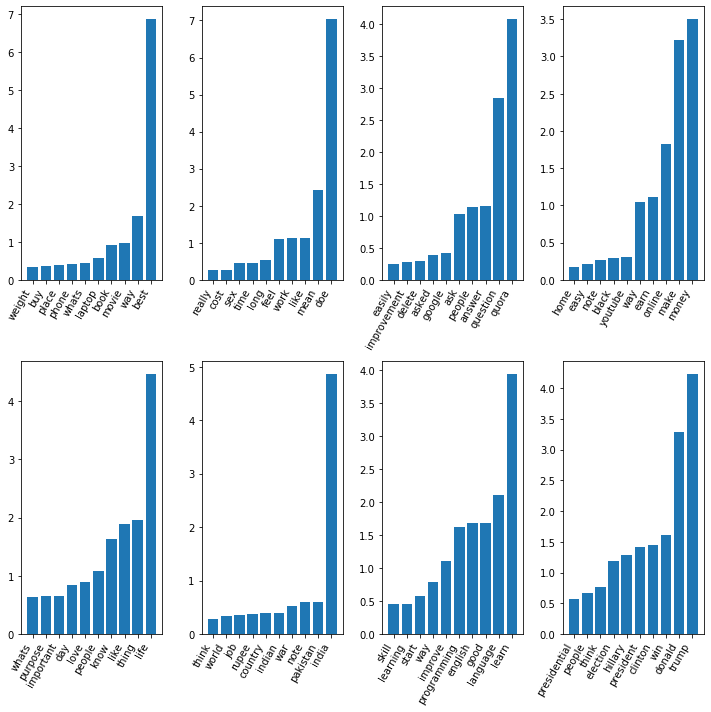

In [28]:
#plot training features
#=======================

feature_names = np.array(tfidf.get_feature_names())
n_components = 8
fig, axes = plt.subplots(2,4, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), model_nmf.components_):
    plot_important_features(coef, feature_names, top_n=10, ax=ax)
    
plt.tight_layout()

In [29]:
# predict on test set
#=====================

topic_test = model_nmf.transform(test_vectors)
topic_test.shape

(121287, 8)

In [30]:
topic_test.argmax(axis=1)

array([5, 0, 1, ..., 5, 5, 6], dtype=int64)

In [31]:
df_test['Topic_NMF'] = topic_test.argmax(axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
#print topics predicted for test set
#====================================
df_test.iloc[1:10,:]

,Question,Topic_SVD,Topic_NMF
6557,best doctor doom story,0,0
139264,newton ring circular shape square shape,1,1
240135,doe wikipedia ensure content quality authentic...,1,1
3336,height would year old increase height,4,4
238994,many people sex,4,4
288817,famous story swami vivekananda,0,4
127604,forget someone love strongly,7,4
80065,sahara average temperature compare one great v...,1,1
134165,whats romantic thing anyone ha ever done,4,4


# Randomized Truncated SVD

In [33]:
u_rsvd, s_rsvd, v_rsvd = randomized_svd(train_vectors,n_components=8)
#u = document vector
#v = topic vector

In [34]:
print(u_rsvd.shape) #(documents,topics)
print(s_rsvd.shape)
print(v_rsvd.shape) #(topics,terms)

(283002, 8)
(8,)
(8, 29464)


In [35]:
v_rsvd

array([[ 8.79260158e-06,  1.69226544e-05,  6.18247414e-06, ...,
         6.29657448e-06,  2.43196973e-06,  6.07690238e-06],
       [ 1.49545168e-05,  1.21828962e-05,  1.21749878e-05, ...,
         1.01003300e-06,  5.93296787e-06,  8.49028986e-07],
       [-7.36076138e-07, -4.75067289e-06, -4.62812343e-06, ...,
        -1.83273462e-06, -3.47619533e-06, -1.72829798e-06],
       ...,
       [ 1.36384784e-05, -1.25050669e-05, -3.45414100e-06, ...,
        -5.19950586e-06, -1.98367658e-05, -5.07458219e-06],
       [-6.13840090e-06,  2.12274464e-05, -2.26041800e-06, ...,
         4.16067442e-05, -1.62141955e-05,  4.12792339e-05],
       [ 9.32363442e-06,  1.00657036e-05, -5.95721360e-06, ...,
        -4.11257643e-05, -2.57697420e-05, -4.08980718e-05]])

In [36]:
len(v_rsvd[0])

29464

In [37]:
#print top 15 words for the topics
#==================================
for index,topic in enumerate(v_rsvd):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['language', 'laptop', 'life', 'quora', 'whats', 'doe', 'online', 'make', 'money', 'movie', 'india', 'book', 'learn', 'way', 'best']


THE TOP 15 WORDS FOR TOPIC #1
['online', 'know', 'life', 'work', 'feel', 'ask', 'answer', 'mean', 'money', 'like', 'make', 'people', 'question', 'quora', 'doe']


THE TOP 15 WORDS FOR TOPIC #2
['add', 'post', 'needing', 'answered', 'easily', 'improvement', 'delete', 'google', 'asked', 'best', 'people', 'ask', 'answer', 'question', 'quora']


THE TOP 15 WORDS FOR TOPIC #3
['banning', 'month', 'home', 'rupee', 'good', 'easiest', 'easy', 'black', 'note', 'youtube', 'earn', 'way', 'online', 'make', 'money']


THE TOP 15 WORDS FOR TOPIC #4
['new', 'important', 'whats', 'day', 'donald', 'good', 'love', 'think', 'trump', 'india', 'know', 'like', 'thing', 'people', 'life']


THE TOP 15 WORDS FOR TOPIC #5
['indian', 'good', 'pakistan', 'note', 'war', 'think', 'election', 'hillary', 'people', 'clinton', 'president', 'win', 'donald', 

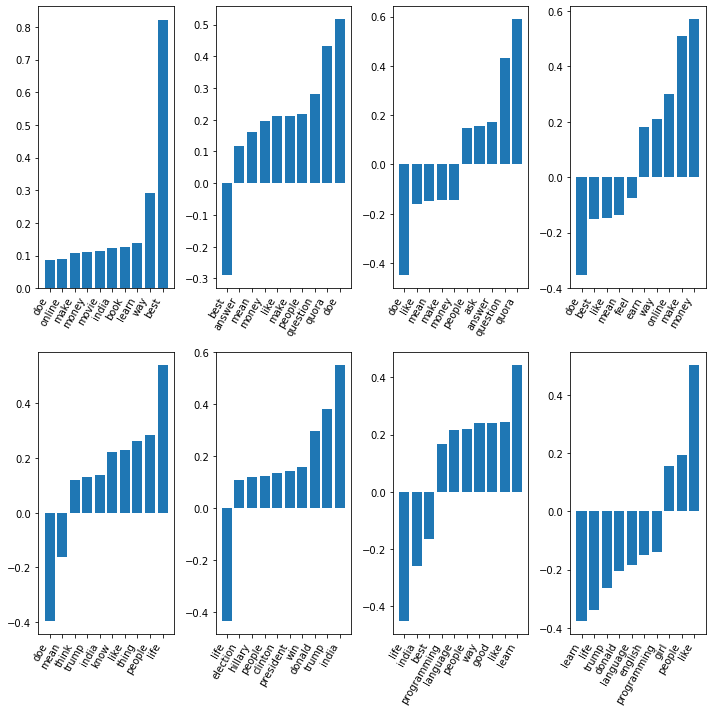

In [38]:
#plot training features
#=======================

feature_names = np.array(tfidf.get_feature_names())
n_components = 8
fig, axes = plt.subplots(2,4, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), v_rsvd):
    plot_important_features(coef, feature_names, top_n=10, ax=ax)
    
plt.tight_layout()

In [39]:
# predict on test set
#=====================

test_vectors_transformed_rsvd= test_vectors@v_rsvd.T

In [40]:
print(test_vectors.shape)
print(test_vectors_transformed_rsvd.shape)

(121287, 29464)
(121287, 8)


In [41]:
df_test['Topic_RSVD'] = test_vectors_transformed_rsvd.argmax(axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
#print topics predicted for test set
#====================================
df_test.iloc[1:10,:]

,Question,Topic_SVD,Topic_NMF,Topic_RSVD
6557,best doctor doom story,0,0,0
139264,newton ring circular shape square shape,1,1,1
240135,doe wikipedia ensure content quality authentic...,1,1,1
3336,height would year old increase height,4,4,1
238994,many people sex,4,4,4
288817,famous story swami vivekananda,0,4,0
127604,forget someone love strongly,7,4,6
80065,sahara average temperature compare one great v...,1,1,1
134165,whats romantic thing anyone ha ever done,4,4,4


# Randomized Truncated SVD - Facebook

In [43]:
u_fb, s_fb, v_fb = fbpca.pca(train_vectors,8)

In [44]:
print(u_fb.shape) #(documents,topics)
print(s_fb.shape)
print(v_fb.shape) #(topics,terms)

(283002, 8)
(8,)
(8, 29464)


In [45]:
v_fb

array([[ 4.70754666e-05,  6.13836255e-06,  2.15357303e-05, ...,
         1.74999723e-05,  1.73000605e-05,  7.83410401e-06],
       [ 5.71617193e-05,  9.59341348e-06,  3.39283644e-05, ...,
         1.83966371e-05,  1.18983482e-05,  6.11479348e-06],
       [ 2.30994971e-05, -8.29899314e-07,  1.15917905e-05, ...,
         3.78308381e-06, -2.59294936e-06, -2.86805909e-06],
       ...,
       [ 2.32045659e-05,  9.70572805e-05, -1.54326121e-05, ...,
         2.29440597e-05, -1.91498493e-05,  2.11428521e-05],
       [-5.96210885e-05, -5.97113311e-06, -1.95202140e-05, ...,
        -3.39287228e-05, -3.00453154e-06, -2.98151468e-05],
       [ 1.32377257e-04, -3.66713755e-05, -2.26018498e-05, ...,
        -2.96467329e-05, -7.23417525e-05, -2.38304597e-05]])

In [46]:
len(v_fb[0])

29464

In [47]:
#print top 15 words for the topics
#==================================
for index,topic in enumerate(v_fb):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['dont', 'work', 'think', 'feel', 'ask', 'good', 'mean', 'know', 'difference', 'like', 'question', 'life', 'people', 'quora', 'doe']


THE TOP 15 WORDS FOR TOPIC #1
['feel', 'war', 'world', 'phone', 'woman', 'think', 'lose', 'election', 'weight', 'life', 'donald', 'win', 'like', 'trump', 'difference']


THE TOP 15 WORDS FOR TOPIC #2
['win', 'rupee', 'good', 'job', 'black', 'donald', 'note', 'difference', 'trump', 'way', 'earn', 'online', 'india', 'make', 'money']


THE TOP 15 WORDS FOR TOPIC #3
['win', 'difference', 'love', 'thing', 'start', 'book', 'donald', 'programming', 'question', 'quora', 'trump', 'improve', 'learn', 'language', 'english']


THE TOP 15 WORDS FOR TOPIC #4
['hillary', 'make', 'best', 'clinton', 'important', 'win', 'movie', 'like', 'thing', 'think', 'donald', 'love', 'trump', 'people', 'life']


THE TOP 15 WORDS FOR TOPIC #5
['old', 'website', 'difference', 'new', 'phone', 'english', 'way', 'improve', 'learn', 'girl', 'time', 'year', 'p

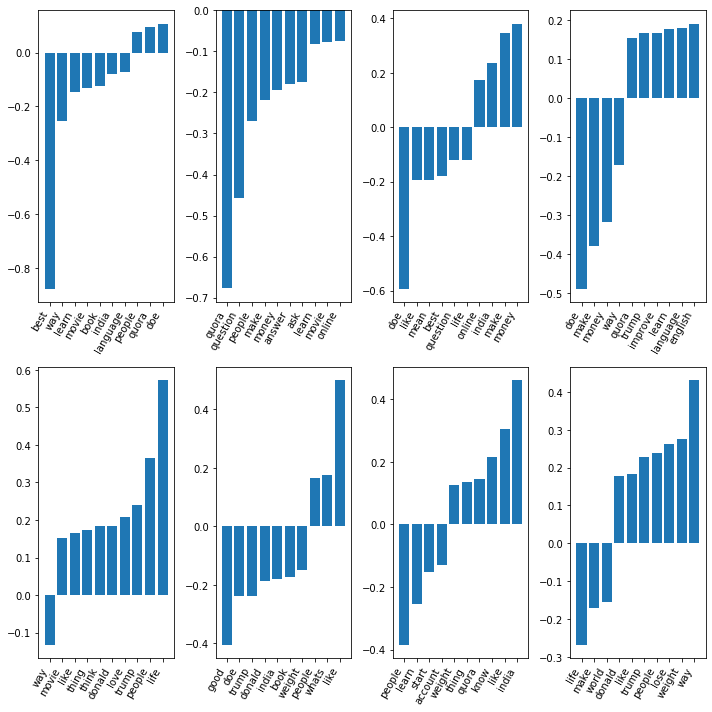

In [48]:
#plot training features
#=======================

feature_names = np.array(tfidf.get_feature_names())
n_components = 8
fig, axes = plt.subplots(2,4, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), v_fb):
    plot_important_features(coef, feature_names, top_n=10, ax=ax)
    
plt.tight_layout()

In [49]:
# predict on test set
#=====================

test_vectors_transformed_fb= test_vectors@v_fb.T

In [50]:
print(test_vectors.shape)
print(test_vectors_transformed_fb.shape)

(121287, 29464)
(121287, 8)


In [51]:
df_test['Topic_RSVD_FB'] = test_vectors_transformed_fb.argmax(axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [52]:
#print topics predicted for test set
#====================================
df_test.iloc[1:10,:]

,Question,Topic_SVD,Topic_NMF,Topic_RSVD,Topic_RSVD_FB
6557,best doctor doom story,0,0,0,4
139264,newton ring circular shape square shape,1,1,1,1
240135,doe wikipedia ensure content quality authentic...,1,1,1,0
3336,height would year old increase height,4,4,1,7
238994,many people sex,4,4,4,4
288817,famous story swami vivekananda,0,4,0,4
127604,forget someone love strongly,7,4,6,4
80065,sahara average temperature compare one great v...,1,1,1,0
134165,whats romantic thing anyone ha ever done,4,4,4,4


# Latent Dirichlet Allocation - LDA

In [53]:
model_lda = LatentDirichletAllocation(n_components=8,random_state=42)

In [54]:
# fit the model to train data
#=============================
model_lda.fit(train_vectors)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=8, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [55]:
print(len(model_lda.components_))
model_lda.components_

8


array([[0.12500008, 0.12500015, 0.12501188, ..., 0.12500007, 0.12500003,
        0.12500007],
       [3.45507595, 0.12500017, 0.12500005, ..., 0.12500008, 1.26268529,
        0.12500008],
       [0.1250001 , 1.32565996, 0.12500004, ..., 0.12500008, 0.12500004,
        0.12500008],
       ...,
       [0.12531073, 0.12500017, 1.5865983 , ..., 0.12511846, 0.12500004,
        0.12510733],
       [0.12500008, 0.1263455 , 0.12500004, ..., 0.12500007, 0.12500003,
        0.12500006],
       [0.12500008, 0.12500014, 0.12500003, ..., 0.12500006, 0.12500003,
        0.12500006]])

In [56]:
#print top 15 words for the topics
#==================================
for index,topic in enumerate(model_lda.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['doe', 'exam', 'business', 'time', 'ask', 'way', 'prepare', 'answer', 'earn', 'best', 'online', 'make', 'question', 'quora', 'money']


THE TOP 15 WORDS FOR TOPIC #1
['visit', 'tv', 'time', 'place', 'song', 'good', 'watch', 'doe', 'movie', 'youtube', 'video', 'read', 'favorite', 'book', 'best']


THE TOP 15 WORDS FOR TOPIC #2
['depression', 'book', 'difference', 'window', 'review', 'learning', 'good', 'india', 'startup', 'digital', 'hair', 'marketing', 'doe', 'movie', 'best']


THE TOP 15 WORDS FOR TOPIC #3
['day', 'woman', 'buy', 'india', 'know', 'laptop', 'year', 'doe', 'phone', 'new', 'sex', 'thing', 'best', 'note', 'life']


THE TOP 15 WORDS FOR TOPIC #4
['election', 'doe', 'hillary', 'clinton', 'think', 'people', 'win', 'president', 'war', 'country', 'india', 'world', 'donald', 'love', 'trump']


THE TOP 15 WORDS FOR TOPIC #5
['sentence', 'email', 'difference', 'password', 'god', 'best', 'word', 'doe', 'skill', 'way', 'account', 'lose', 'improve', 'w

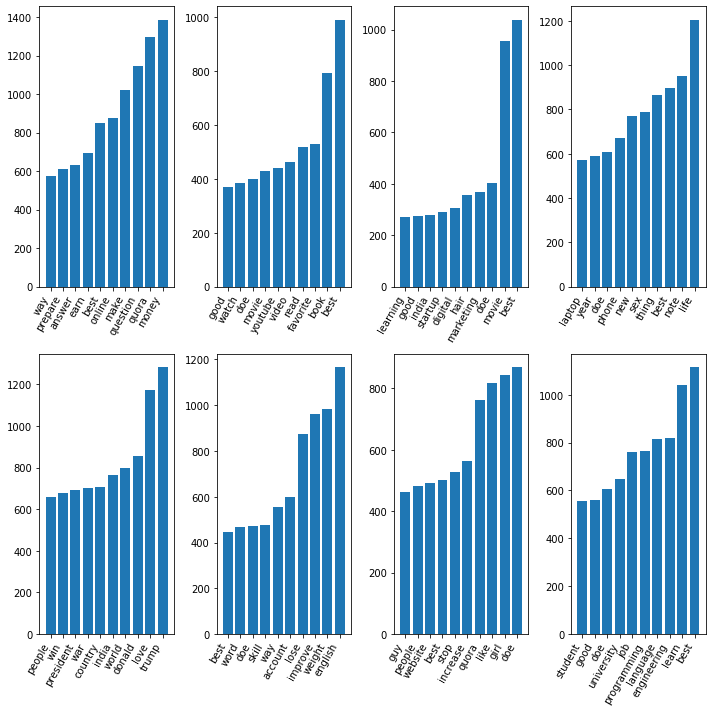

In [57]:
#plot training features
#=======================

feature_names = np.array(tfidf.get_feature_names())
n_components = 8
fig, axes = plt.subplots(2,4, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), model_lda.components_):
    plot_important_features(coef, feature_names, top_n=10, ax=ax)
    
plt.tight_layout()

In [58]:
# predict on test set
#=====================

topic_test = model_lda.transform(test_vectors)
topic_test.shape

(121287, 8)

In [59]:
topic_test.argmax(axis=1)

array([4, 6, 1, ..., 2, 1, 7], dtype=int64)

In [60]:
df_test['Topic_LDA'] = topic_test.argmax(axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [61]:
#print topics predicted for test set
#====================================
df_test.iloc[1:10,:]

,Question,Topic_SVD,Topic_NMF,Topic_RSVD,Topic_RSVD_FB,Topic_LDA
6557,best doctor doom story,0,0,0,4,6
139264,newton ring circular shape square shape,1,1,1,1,1
240135,doe wikipedia ensure content quality authentic...,1,1,1,0,0
3336,height would year old increase height,4,4,1,7,6
238994,many people sex,4,4,4,4,3
288817,famous story swami vivekananda,0,4,0,4,6
127604,forget someone love strongly,7,4,6,4,1
80065,sahara average temperature compare one great v...,1,1,1,0,7
134165,whats romantic thing anyone ha ever done,4,4,4,4,1


# Conclusion and Explanation

I have grouped words into 8 meaningful topics. The words are classified into categories like recreation, emotions, social networking, revenue, economy, education, romance and election & politics.

The strong dependencies of the Words like 'presidency','vote', 'Hillary', 'president', 'clinton', 'win', 'donald', 'trump' indicate these belong to election & politics topic. Similarly other topics include related words. 

From the above results we can see that with 8 components SVD, NMF, R-SVD & R-SVD FB predict almost similar topics. LDA provides different set of topic predictions for the same documents.   